# 001: Seeking Diffusion

**The Encounter Hypothesis**

Do unreachable tokens escape the primordial cluster via Brownian diffusion + rare prediction encounters?

## The Mechanism

1. **t=0:** All unreachable tokens crystallized on bfloat16 lattice, indistinguishable singularity
2. **Early thermal diffusion:** Some tokens get lucky with Brownian motion, nudge outside core
3. **Event horizon crossing:** Once distinguishable, token CAN be predicted (rarely)
4. **Encounter kicks:** Wrong predictions → big gradient kicks → further displacement
5. **Positive feedback:** More distinguishable → higher prediction rate → more kicks → escape

## Testable Predictions

- **Core tokens:** Smooth thermal noise, no gradient spikes, stay together
- **Escaped tokens:** Episodic large kicks, increasing distance from core
- **Event horizon:** Critical distance where encounter rate jumps

## Data

Using comprehensive Gatsby training data (f32→bf16, 10k steps):
- 128 total tokens (51 dead, 77 live)
- 64-dimensional embedding space
- 10,001 timesteps (steps 0-10,000)
- Full embeddings, gradients, Adam momentum/variance, logits, losses

## This Notebook

Visual exploration. Pick a core token (stayed in big BH) and an escaped token (ended as singleton). Plot trajectories, gradients, see if encounter signature jumps out.

## Parameters

In [ ]:
DATA_PATH = "../../data/comprehensive_run/comprehensive_training_data.safetensors"

# We'll pick specific tokens after loading and identifying core vs escaped
CORE_TOKEN_ID = None  # TBD: token that stayed in largest BH
ESCAPED_TOKEN_ID = /.  # TBD: token that ended as singleton

# Visualization
FIGSIZE = (14, 10)
DPI = 150

## Imports

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors import safe_open
from pathlib import Path

## Device Detection

In [11]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [12]:
# Load the comprehensive training data
data_path = Path(DATA_PATH)

print(f"Loading: {data_path}")

with safe_open(data_path, framework='pt', device='cpu') as f:
    embeddings = f.get_tensor('embeddings').to(device)  # (10001, 128, 64)
    grads = f.get_tensor('grads').to(device)  # (10001, 128, 64)
    logits = f.get_tensor('logits').to(device)  # (10001, 128)
    losses = f.get_tensor('losses').to(device)  # (10001,)
    dead_token_ids = f.get_tensor('dead_token_ids')  # (51,)
    live_token_ids = f.get_tensor('live_token_ids')  # (77,)
    recorded_steps = f.get_tensor('recorded_steps')  # (10001,)

n_steps, vocab_size, d = embeddings.shape

print(f"\nLoaded data:")
print(f"  Embeddings: {embeddings.shape}")
print(f"  Gradients: {grads.shape}")
print(f"  Logits: {logits.shape}")
print(f"  Steps: {n_steps}")
print(f"  Vocabulary: {vocab_size} tokens")
print(f"  Dimensions: {d}")
print(f"  Dead tokens: {len(dead_token_ids)}")
print(f"  Live tokens: {len(live_token_ids)}")

Loading: ../../data/comprehensive_run/comprehensive_training_data.safetensors

Loaded data:
  Embeddings: torch.Size([10001, 128, 64])
  Gradients: torch.Size([10001, 128, 64])
  Logits: torch.Size([10001, 128])
  Steps: 10001
  Vocabulary: 128 tokens
  Dimensions: 64
  Dead tokens: 51
  Live tokens: 77


## Identify Dead Token Structure at t=10000

Find black holes (duplicates) among the 51 dead tokens.

In [13]:
# Get final embeddings for dead tokens only
W_final = embeddings[-1]  # Last timestep (t=10000)
dead_embeddings = W_final[dead_token_ids]

print(f"Final dead token embeddings: {dead_embeddings.shape}")

Final dead token embeddings: torch.Size([51, 64])


In [14]:
# Find unique vectors (black hole detection)
unique_vectors = []
unique_token_ids = []  # Original token IDs in vocab
populations = []
token_to_unique = {}  # Maps dead token index → unique vector index

for i, token_id in enumerate(dead_token_ids):
    v = dead_embeddings[i]
    
    # Check if this vector matches any existing unique vector
    found = False
    for j, u in enumerate(unique_vectors):
        if torch.allclose(v, u, rtol=0, atol=0):  # Exact match
            populations[j] += 1
            token_to_unique[token_id.item()] = j
            found = True
            break
    
    if not found:
        unique_vectors.append(v)
        unique_token_ids.append(token_id.item())
        populations.append(1)
        token_to_unique[token_id.item()] = len(unique_vectors) - 1

print(f"\nFound {len(unique_vectors)} unique vectors")
print(f"Populations (sorted): {sorted(populations, reverse=True)}")


Found 17 unique vectors
Populations (sorted): [13, 10, 5, 4, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]


In [15]:
# Identify largest black hole (core) and singletons (escaped)
max_pop = max(populations)
core_idx = populations.index(max_pop)

# Get all dead tokens belonging to core
core_tokens = [tid for tid, uidx in token_to_unique.items() if uidx == core_idx]

# Get all singletons
singleton_indices = [i for i, pop in enumerate(populations) if pop == 1]
singleton_tokens = [unique_token_ids[i] for i in singleton_indices]

print(f"\nCore black hole:")
print(f"  Population: {max_pop}")
print(f"  Token IDs: {core_tokens[:10]}..." if len(core_tokens) > 10 else f"  Token IDs: {core_tokens}")

print(f"\nSingletons: {len(singleton_tokens)}")
print(f"  Token IDs: {singleton_tokens[:10]}..." if len(singleton_tokens) > 10 else f"  Token IDs: {singleton_tokens}")


Core black hole:
  Population: 13
  Token IDs: [3, 11, 12, 22, 23, 34, 43, 47, 61, 94]...

Singletons: 8
  Token IDs: [4, 6, 8, 9, 13, 38, 92, 96]


## Pick Representative Tokens

Choose one core token and one escaped token for detailed analysis.

In [16]:
# Pick first token from core and first singleton
CORE_TOKEN_ID = core_tokens[0]
ESCAPED_TOKEN_ID = singleton_tokens[0] if singleton_tokens else None

print(f"Selected tokens for comparison:")
print(f"  Core token: {CORE_TOKEN_ID}")
print(f"  Escaped token: {ESCAPED_TOKEN_ID}")

if ESCAPED_TOKEN_ID is None:
    print("\n⚠️  No singletons found! All dead tokens collapsed into black holes.")
    print("    Will only analyze core token dynamics.")

Selected tokens for comparison:
  Core token: 3
  Escaped token: 4


## Compute Dead Token Centroid Over Time

To measure "distance from core," we need the core's center of mass at each timestep.

In [17]:
# Compute centroid of all dead tokens at each timestep
print(f"Computing dead token centroid trajectory...")

dead_centroids = embeddings[:, dead_token_ids].mean(dim=1)  # (n_steps, d)

print(f"✓ Dead token centroid: {dead_centroids.shape}")

Computing dead token centroid trajectory...
✓ Dead token centroid: torch.Size([10001, 64])


## Extract Token Trajectories

In [18]:
# Extract position and gradient trajectories
core_positions = embeddings[:, CORE_TOKEN_ID, :]  # (n_steps, d)
core_grads = grads[:, CORE_TOKEN_ID, :]  # (n_steps, d)

if ESCAPED_TOKEN_ID is not None:
    escaped_positions = embeddings[:, ESCAPED_TOKEN_ID, :]  # (n_steps, d)
    escaped_grads = grads[:, ESCAPED_TOKEN_ID, :]  # (n_steps, d)

print(f"✓ Trajectories extracted")

✓ Trajectories extracted


## Compute Distance from Dead Token Centroid

In [19]:
# L2 distance from dead token centroid at each timestep
core_distances = torch.linalg.vector_norm(
    core_positions - dead_centroids, dim=1
).cpu().numpy()

if ESCAPED_TOKEN_ID is not None:
    escaped_distances = torch.linalg.vector_norm(
        escaped_positions - dead_centroids, dim=1
    ).cpu().numpy()

print(f"Distance from dead token centroid:")
print(f"  Core token: {core_distances[-1]:.6e} (final)")
if ESCAPED_TOKEN_ID is not None:
    print(f"  Escaped token: {escaped_distances[-1]:.6e} (final)")

Distance from dead token centroid:
  Core token: 1.839642e-03 (final)
  Escaped token: 1.626549e-03 (final)


## Compute Gradient Magnitudes

In [20]:
# L2 norm of gradients
core_grad_mags = torch.linalg.vector_norm(core_grads, dim=1).cpu().numpy()

if ESCAPED_TOKEN_ID is not None:
    escaped_grad_mags = torch.linalg.vector_norm(escaped_grads, dim=1).cpu().numpy()

print(f"✓ Gradient magnitudes computed")

✓ Gradient magnitudes computed


## Visualization: Trajectory Comparison

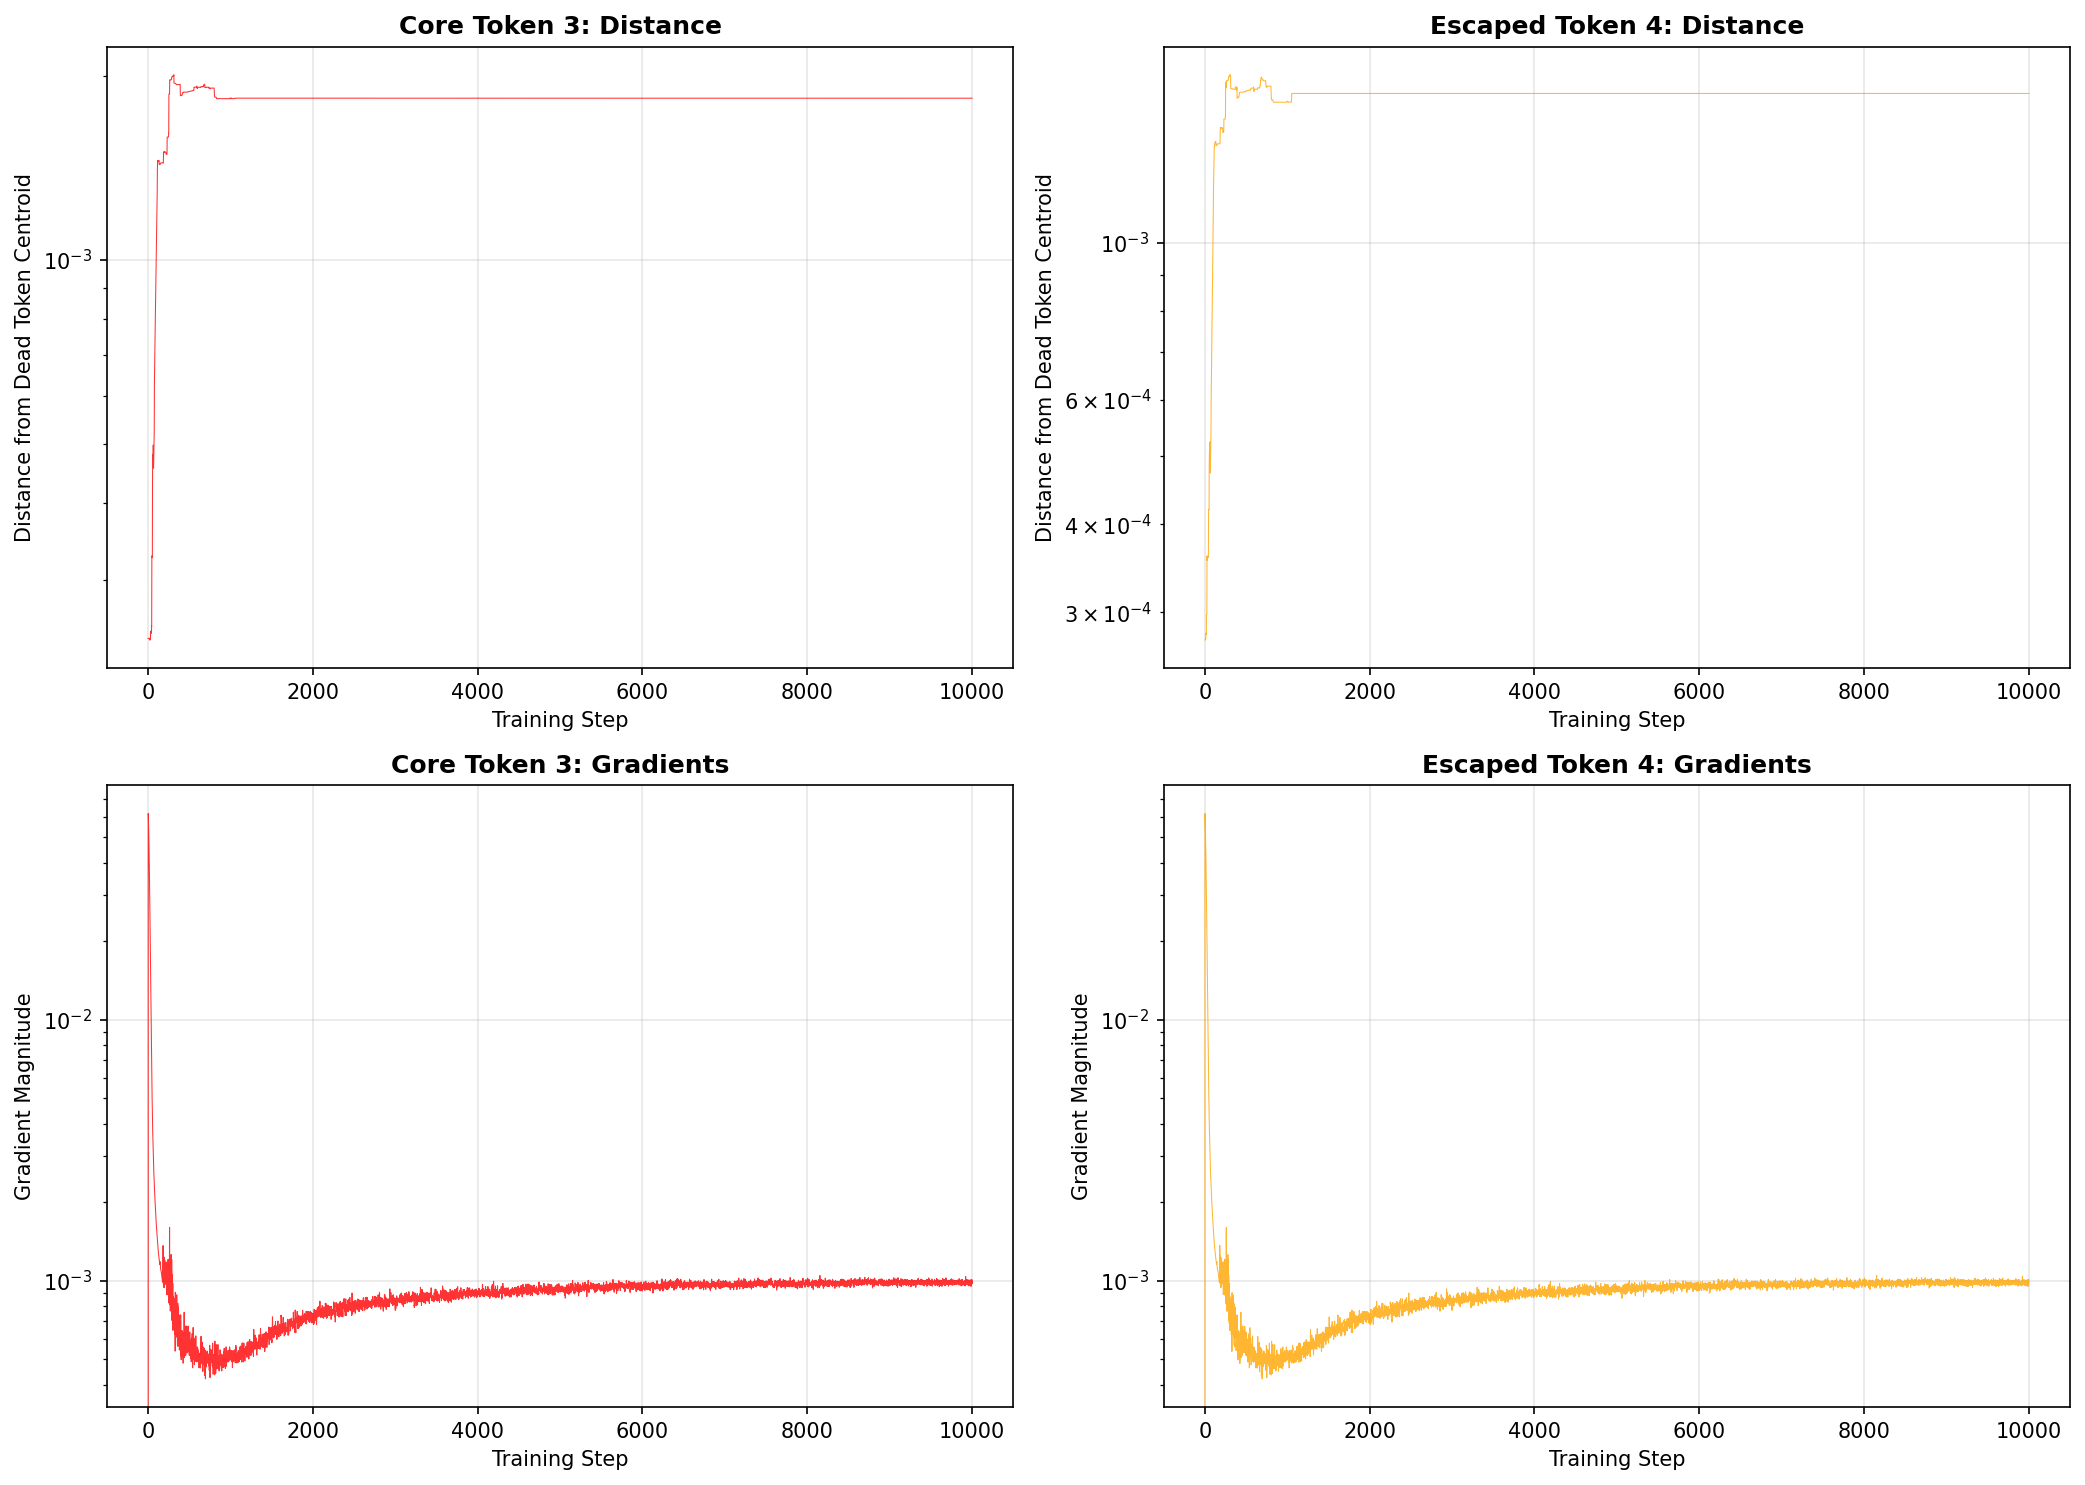


✓ Trajectory comparison complete


In [21]:
if ESCAPED_TOKEN_ID is not None:
    # Side-by-side comparison
    fig, axes = plt.subplots(2, 2, figsize=FIGSIZE, dpi=DPI)
    
    steps = recorded_steps.cpu().numpy()
    
    # Top left: Core token distance from centroid
    ax = axes[0, 0]
    ax.plot(steps, core_distances, color='red', linewidth=0.5, alpha=0.8)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Distance from Dead Token Centroid')
    ax.set_title(f'Core Token {CORE_TOKEN_ID}: Distance', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # Top right: Escaped token distance from centroid
    ax = axes[0, 1]
    ax.plot(steps, escaped_distances, color='orange', linewidth=0.5, alpha=0.8)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Distance from Dead Token Centroid')
    ax.set_title(f'Escaped Token {ESCAPED_TOKEN_ID}: Distance', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # Bottom left: Core token gradient magnitude
    ax = axes[1, 0]
    ax.plot(steps, core_grad_mags, color='red', linewidth=0.5, alpha=0.8)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Gradient Magnitude')
    ax.set_title(f'Core Token {CORE_TOKEN_ID}: Gradients', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # Bottom right: Escaped token gradient magnitude
    ax = axes[1, 1]
    ax.plot(steps, escaped_grad_mags, color='orange', linewidth=0.5, alpha=0.8)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Gradient Magnitude')
    ax.set_title(f'Escaped Token {ESCAPED_TOKEN_ID}: Gradients', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()
else:
    # Only core token (no singletons to compare)
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), dpi=DPI)
    
    steps = recorded_steps.cpu().numpy()
    
    # Top: Distance from centroid
    ax = axes[0]
    ax.plot(steps, core_distances, color='red', linewidth=0.5, alpha=0.8)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Distance from Dead Token Centroid')
    ax.set_title(f'Core Token {CORE_TOKEN_ID}: Distance', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # Bottom: Gradient magnitude
    ax = axes[1]
    ax.plot(steps, core_grad_mags, color='red', linewidth=0.5, alpha=0.8)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Gradient Magnitude')
    ax.set_title(f'Core Token {CORE_TOKEN_ID}: Gradients', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

print("\n✓ Trajectory comparison complete")

## Observations

**What to look for:**

1. **Distance trajectories:**
   - Does escaped token show monotonic increase?
   - Does core token stay flat/oscillate near zero?
   - Is there an identifiable "escape event"?

2. **Gradient patterns:**
   - Does escaped token show episodic spikes (encounters)?
   - Does core token show smooth decay (thermal noise only)?
   - Do gradient spikes correlate with distance increases?

3. **Event horizon:**
   - Is there a critical distance where behavior changes?
   - Does escape accelerate after crossing some threshold?

**Encounter hypothesis predictions:**
- Core tokens: buried in singularity, indistinguishable, only thermal updates
- Escaped tokens: Brownian walk → distinguishable → rare predictions → kicks → positive feedback → full escape